<a href="https://colab.research.google.com/github/Srividhyak2011/Demo-Datascienceproject/blob/main/Copy_of_Copy_of_M5_MP7_NB_StockMarket.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Applied Data Science and Machine Intelligence
## A program by IIT Madras and TalentSprint
### Mini Project Notebook: Stock Prices Anomaly Detection

## Learning Objectives

At the end of the experiment, you will be able to :

* apply PCA based analysis on various stocks data
* analyze and create time series data
* implement LSTM auto-encoders
* detect the anomalies based on the loss


## Information

Autoencoder Neural Networks try to learn data representation of its input. Usually, we want to learn an efficient encoding that uses fewer parameters/memory. The encoding should allow for output similar to the original input. In a sense, we’re forcing the model to learn the most important features of the data using as few parameters as possible.

LSTM autoencoder is an encoder that makes use of LSTM encoder-decoder architecture to compress data using an encoder and decode it to retain original structure using a decoder.

**Anomaly Detection**

Anomaly detection refers to the task of finding/identifying rare events/data points. Some applications include - bank fraud detection, tumor detection in medical imaging, and errors in written text.

A lot of supervised and unsupervised approaches for anomaly detection have been proposed. Some of the approaches include - One-class SVMs, Bayesian Networks, Cluster analysis, and Neural Networks.

We will use an LSTM Autoencoder Neural Network to detect/predict anomalies (sudden price changes) in the S&P 500 index.

## Dataset



This mini-project consists of two parts and two different stock price datasets:

### PART A

Using the **S&P 500 stock prices data of different companies**, we will perform a PCA based analysis.

### PART B

Using the **S&P 500 stock price index time series data**, we will perform anomaly detection in the stock prices across the years. The dataset chosen is is S&P500 Daily Index a .csv format with one column with a daily timestamp and the second column with the raw, un-adjusted closing prices for each day. This long term, granular time series dataset allows researchers to have a good sized publicly available financial dataset to explore time series trends or use as part of a quantitative finance project.

## Problem Statement

Detect the stock price anomalies by implementing an LSTM autoencoder

## Grading = 10 Points

In [1]:
#@title Download dataset
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/SPY.csv
!wget -qq https://cdn.iisc.talentsprint.com/CDS/MiniProjects/prices.csv

In [2]:
pip install --upgrade tensorflow

In [3]:
!pip install livelossplot

### Import required packages

In [4]:
import keras
from keras.layers import Activation, Dense, Dropout, Flatten
from keras.layers import LSTM, RepeatVector, TimeDistributed
from tensorflow.keras.layers import BatchNormalization
from sklearn.preprocessing import normalize
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from keras.models import Sequential, Model
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from livelossplot import PlotLossesKerasTF
from keras.models import Sequential   # the model
from keras.models import *
from keras.layers import *
from keras.callbacks import *

## PCA Analysis (PART-A)

Principal Component Analysis (PCA) decomposes the data into many vectors called principal components. These summaries are linear combinations of the input features that try to explain as much variance in the data as possible. By convention, these principal components are ordered by the amount of variance they can explain, with the first principal component explaining most of the data.

Perform PCA based analytics on the stock prices data from different companies.

Hint: Refer to the article [here](https://towardsdatascience.com/stock-market-analytics-with-pca-d1c2318e3f0e).

### Load and pre-process the prices data (1 points)

In [5]:
prices_path = "prices.csv"

In [6]:
prdf=pd.read_csv(prices_path)

In [7]:
prdf.shape

(394, 503)

In [8]:
prdf.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,85.017082,28.982893,157.171890,74.207466,81.950539,82.938141,168.809998,84.622925,204.910950,334.429993,...,59.934875,100.115349,63.633118,56.203197,78.396255,99.349007,147.579269,259.140015,49.903751,132.803421
2,83.652077,27.548195,157.181747,73.486023,81.172668,81.895088,166.820007,83.591301,204.569687,331.809998,...,60.223114,97.810677,63.121540,55.581242,78.857689,99.037834,147.193512,256.049988,49.199547,132.823227
3,83.899353,27.219410,154.598541,74.071579,81.813271,83.094116,179.039993,84.029251,203.233841,333.709991,...,60.136642,95.771927,63.606186,55.887280,78.347168,98.979500,146.342834,258.010010,48.600010,131.803482
4,84.156532,27.119778,152.764648,73.723213,81.346550,82.499466,180.350006,83.562103,198.846008,333.390015,...,60.011738,97.958405,63.085632,56.183449,78.052628,99.154533,146.214264,256.470001,48.305000,132.248978


As we can see the first row is empty. So we removing it.

In [9]:
cprdf=prdf.dropna(how='all')

In [10]:
cprdf.shape

(393, 503)

In [11]:
type(cprdf.isna().sum())

pandas.core.series.Series

In [12]:
icprdf=cprdf.fillna(0)

<ipython-input-13-a7c3b14913de>:5: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


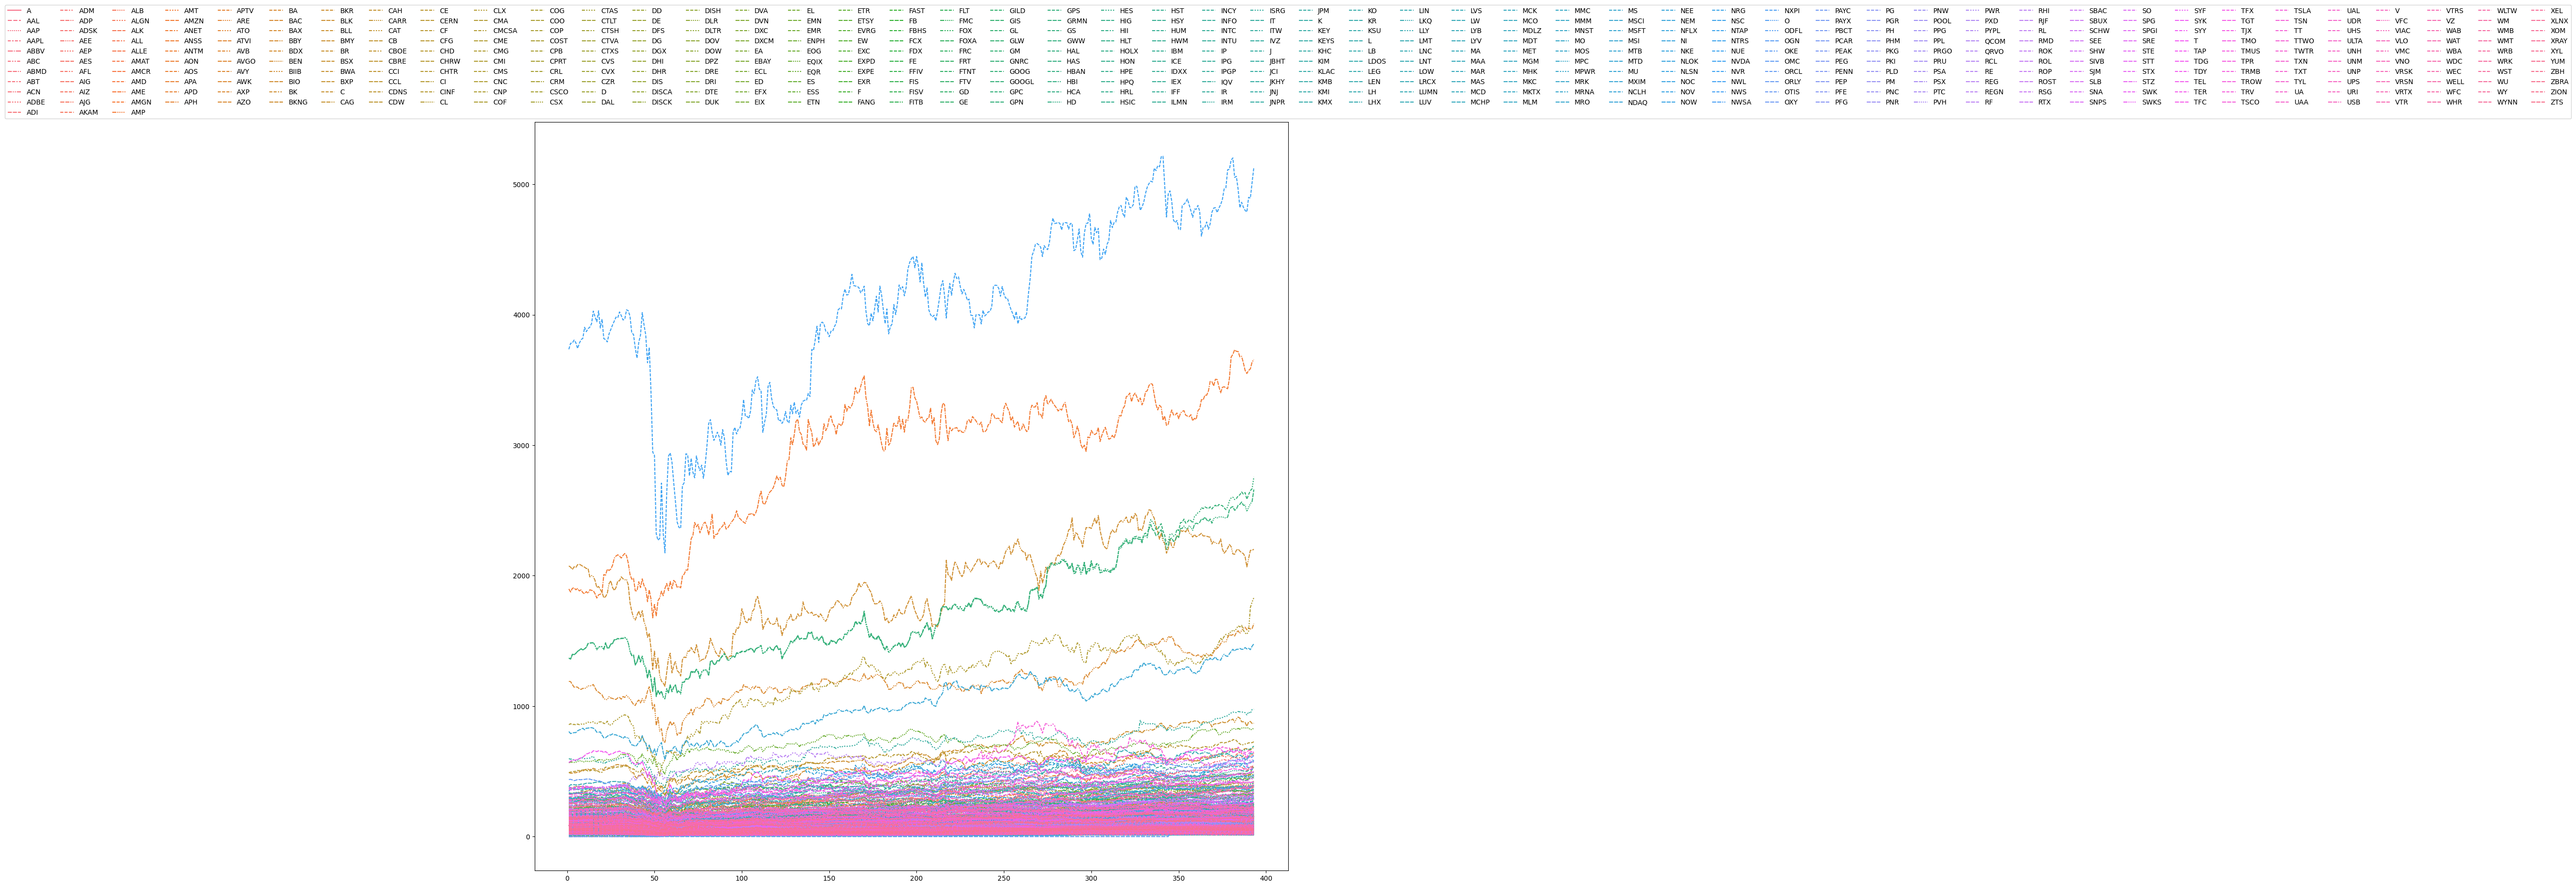

In [13]:
fig = plt.figure(figsize=(20,20))
gp=sns.lineplot(icprdf)
gp.plot(figsize=(50,60), xticks=[], grid=True, title='Stock Price Trends')
gp.legend(loc="lower center", bbox_to_anchor=(1, 1), ncol=50)
plt.tight_layout()

### Apply PCA (2.5 points)

* plot the explained variance ratio. Hint: `pca.explained_variance_ratio_`
* Represent the components which preserve maximum information and plot to visualize
* Compute the daily returns of the 500 company stocks. Hint: See the following [reference](https://towardsdatascience.com/stock-market-analytics-with-pca-d1c2318e3f0e).
* Plot the stocks with most negative and least negative PCA weights in the pandemic period (Year 2020). Use reference as above. Discuss the least and most impacted industrial sectors in terms of stocks.

In [14]:
# YOUR CODE HERE
# Scale the dataset
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(icprdf)
sicprdf=sc.transform(icprdf)

In [15]:
# PCA Implementation
pca = PCA()
psicprdf = pca.fit_transform(sicprdf) ## Determining the transformed features
exp_var_pca = pca.explained_variance_ratio_ # ration of variance (eigenvalue / total eigenvalues). This is to determine  the explained variance using explained_variance_ration_ attribute
cum_sum_eigenvalues = np.cumsum(exp_var_pca) # Cumulative sum of eigenvalue for visualizing the variance explained by each principal component.

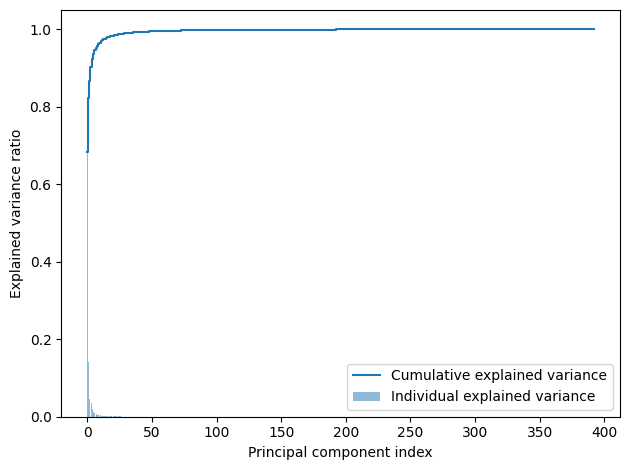

In [16]:
plt.bar(range(0,len(exp_var_pca)), exp_var_pca, alpha=0.5, align='center', label='Individual explained variance')
plt.step(range(0,len(cum_sum_eigenvalues)), cum_sum_eigenvalues, where='mid',label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [17]:
exp_var_pca[0:2]

array([0.68255961, 0.14054853])

In [18]:
icprdf.shape

(393, 503)

In [19]:
rs=icprdf.diff(1)
crs=rs.fillna(0)
crs.head()

,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,ADBE,...,XEL,XLNX,XOM,XRAY,XYL,YUM,ZBH,ZBRA,ZION,ZTS
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,-1.365005,-1.434698,0.009857,-0.721443,-0.777870,-1.043053,-1.989990,-1.031624,-0.341263,-2.619995,...,0.288239,-2.304672,-0.511578,-0.621956,0.461433,-0.311172,-0.385757,-3.090027,-0.704205,0.019806
3,0.247276,-0.328785,-2.583206,0.585556,0.640602,1.199028,12.219986,0.437950,-1.335846,1.899994,...,-0.086472,-2.038750,0.484646,0.306038,-0.510521,-0.058334,-0.850677,1.960022,-0.599537,-1.019745
4,0.257179,-0.099632,-1.833893,-0.348366,-0.466721,-0.594650,1.310013,-0.467148,-4.387833,-0.319977,...,-0.124905,2.186478,-0.520554,0.296169,-0.294540,0.175034,-0.128571,-1.540009,-0.295010,0.445496
5,0.830879,0.617718,-1.755005,1.185936,0.576530,0.799362,-1.660004,0.340637,0.390060,4.479980,...,-0.057652,-0.275764,-0.951359,0.592339,0.265076,0.175034,1.750763,-8.830002,0.475826,-0.287094


In [20]:
crs.shape

(393, 503)

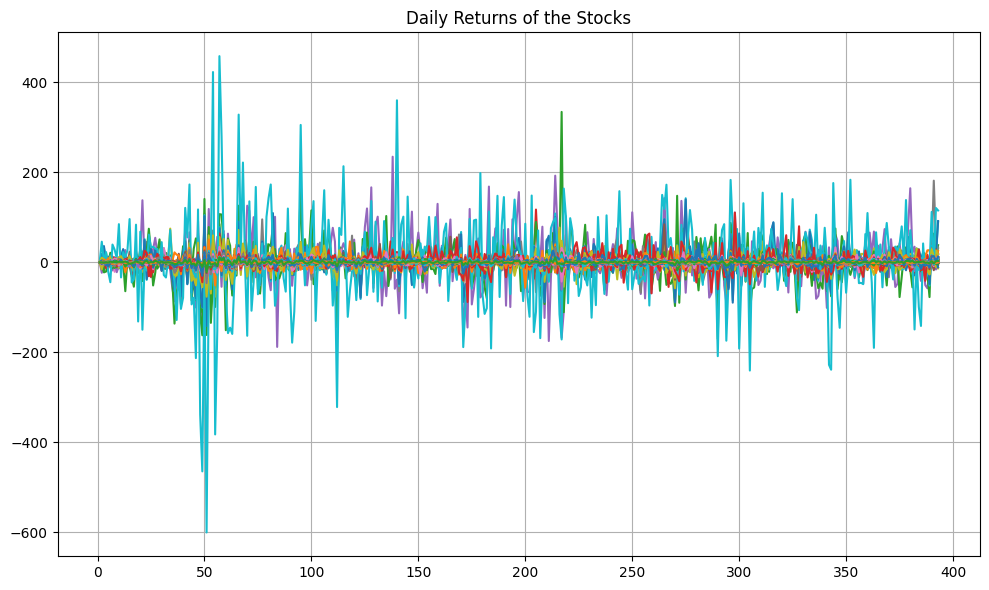

In [21]:
crs.plot(legend=0, figsize=(10,6), grid=True, title='Daily Returns of the Stocks')
plt.tight_layout()

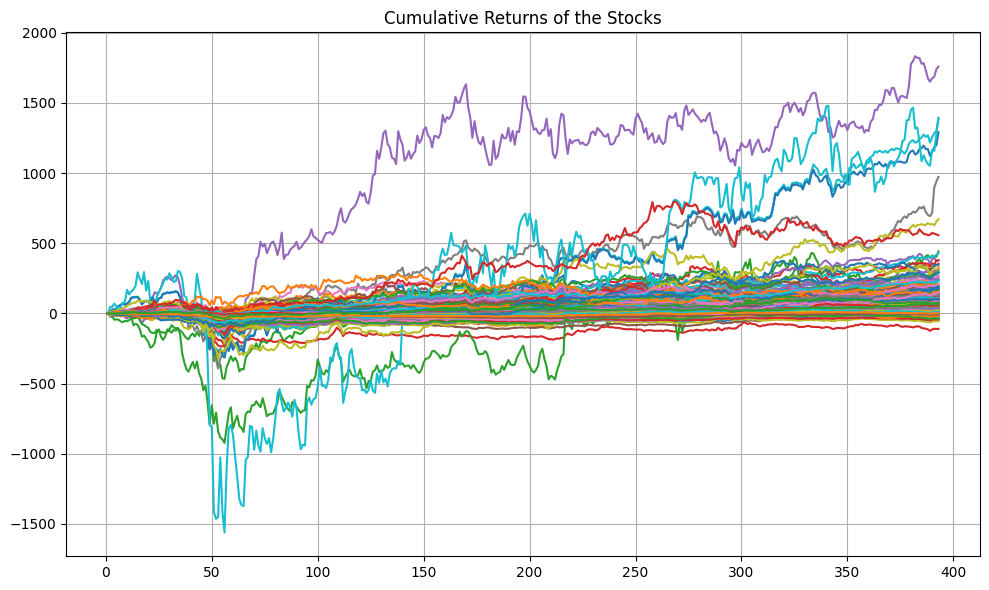

In [22]:
(crs.cumsum()).plot(legend=0, figsize=(10,6), grid=True, title='Cumulative Returns of the Stocks')
plt.tight_layout()

In [23]:
pc1 = pd.Series(index=icprdf.columns, data=pca.components_[0])
pc1

A      -0.050948
AAL    -0.034673
AAP    -0.050870
AAPL   -0.044715
ABBV   -0.049316
          ...   
YUM    -0.052508
ZBH    -0.050306
ZBRA   -0.051033
ZION   -0.049625
ZTS    -0.046105
Length: 503, dtype: float64

<Axes: >

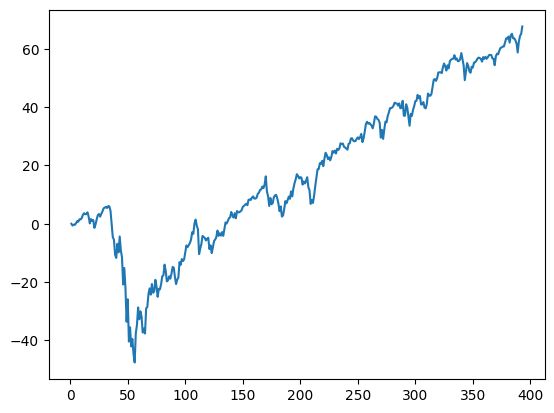

In [24]:
weights = abs(pc1)/sum(abs(pc1))
myrs = (weights*crs).sum(1)
myrs.cumsum().plot()

In [25]:
myrs.shape

(393,)

In [26]:
prs=crs[crs.columns[2]]

<ipython-input-27-75be5ab942ff>:1: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  rs_df = pd.concat([myrs, prs], 1)


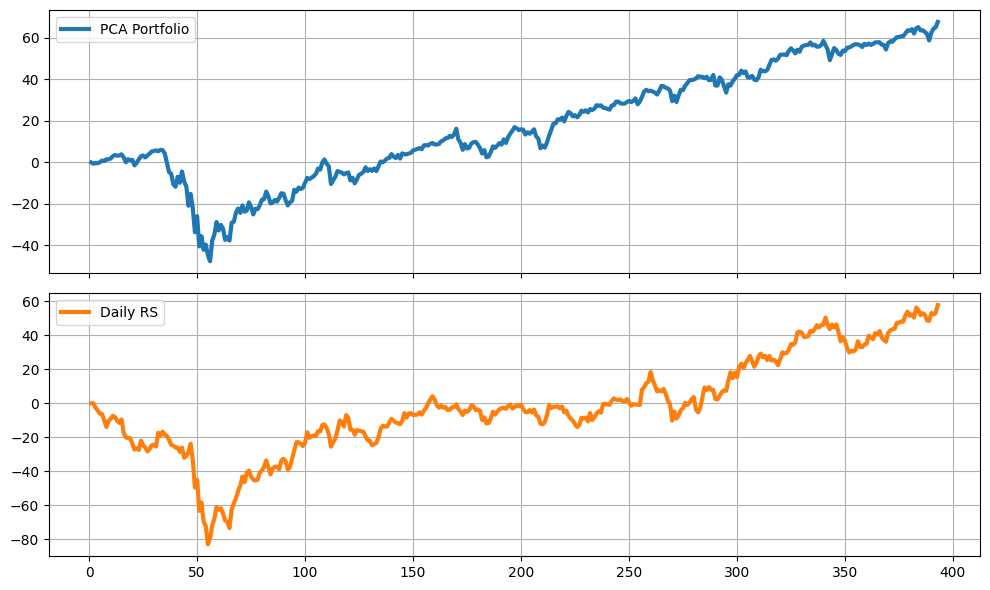

In [27]:
rs_df = pd.concat([myrs, prs], 1)
rs_df.columns = ["PCA Portfolio", "Daily RS"]
rs_df.cumsum().plot(subplots=True, figsize=(10,6), grid=True, linewidth=3);
plt.tight_layout()

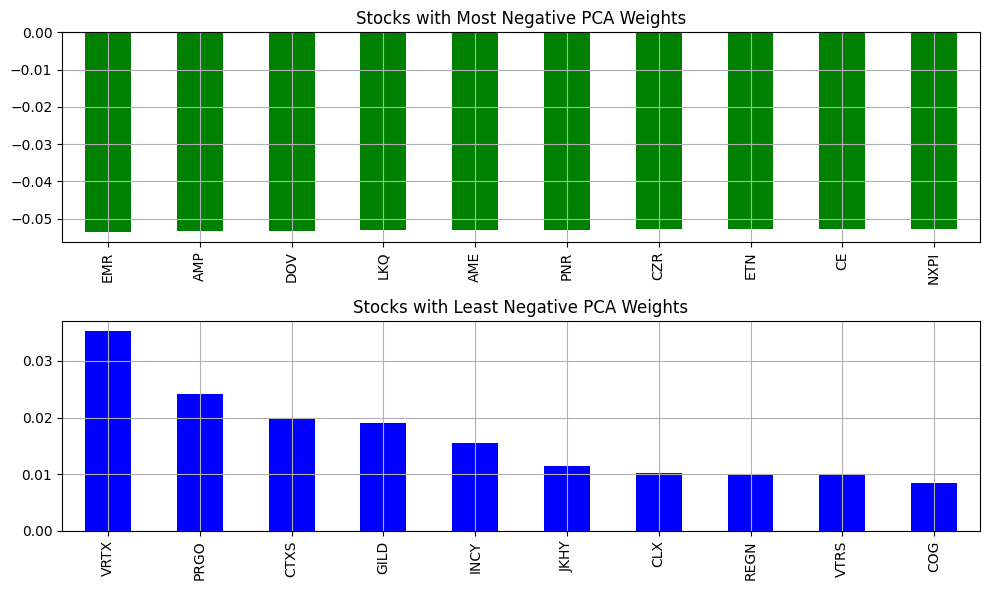

In [28]:
fig, ax = plt.subplots(2,1, figsize=(10,6))
pc1.nsmallest(10).plot.bar(ax=ax[0], color='green', grid=True, title='Stocks with Most Negative PCA Weights')
pc1.nlargest(10).plot.bar(ax=ax[1], color='blue', grid=True, title='Stocks with Least Negative PCA Weights')

plt.tight_layout()

#### Apply T-SNE and visualize with a graph (1 points)

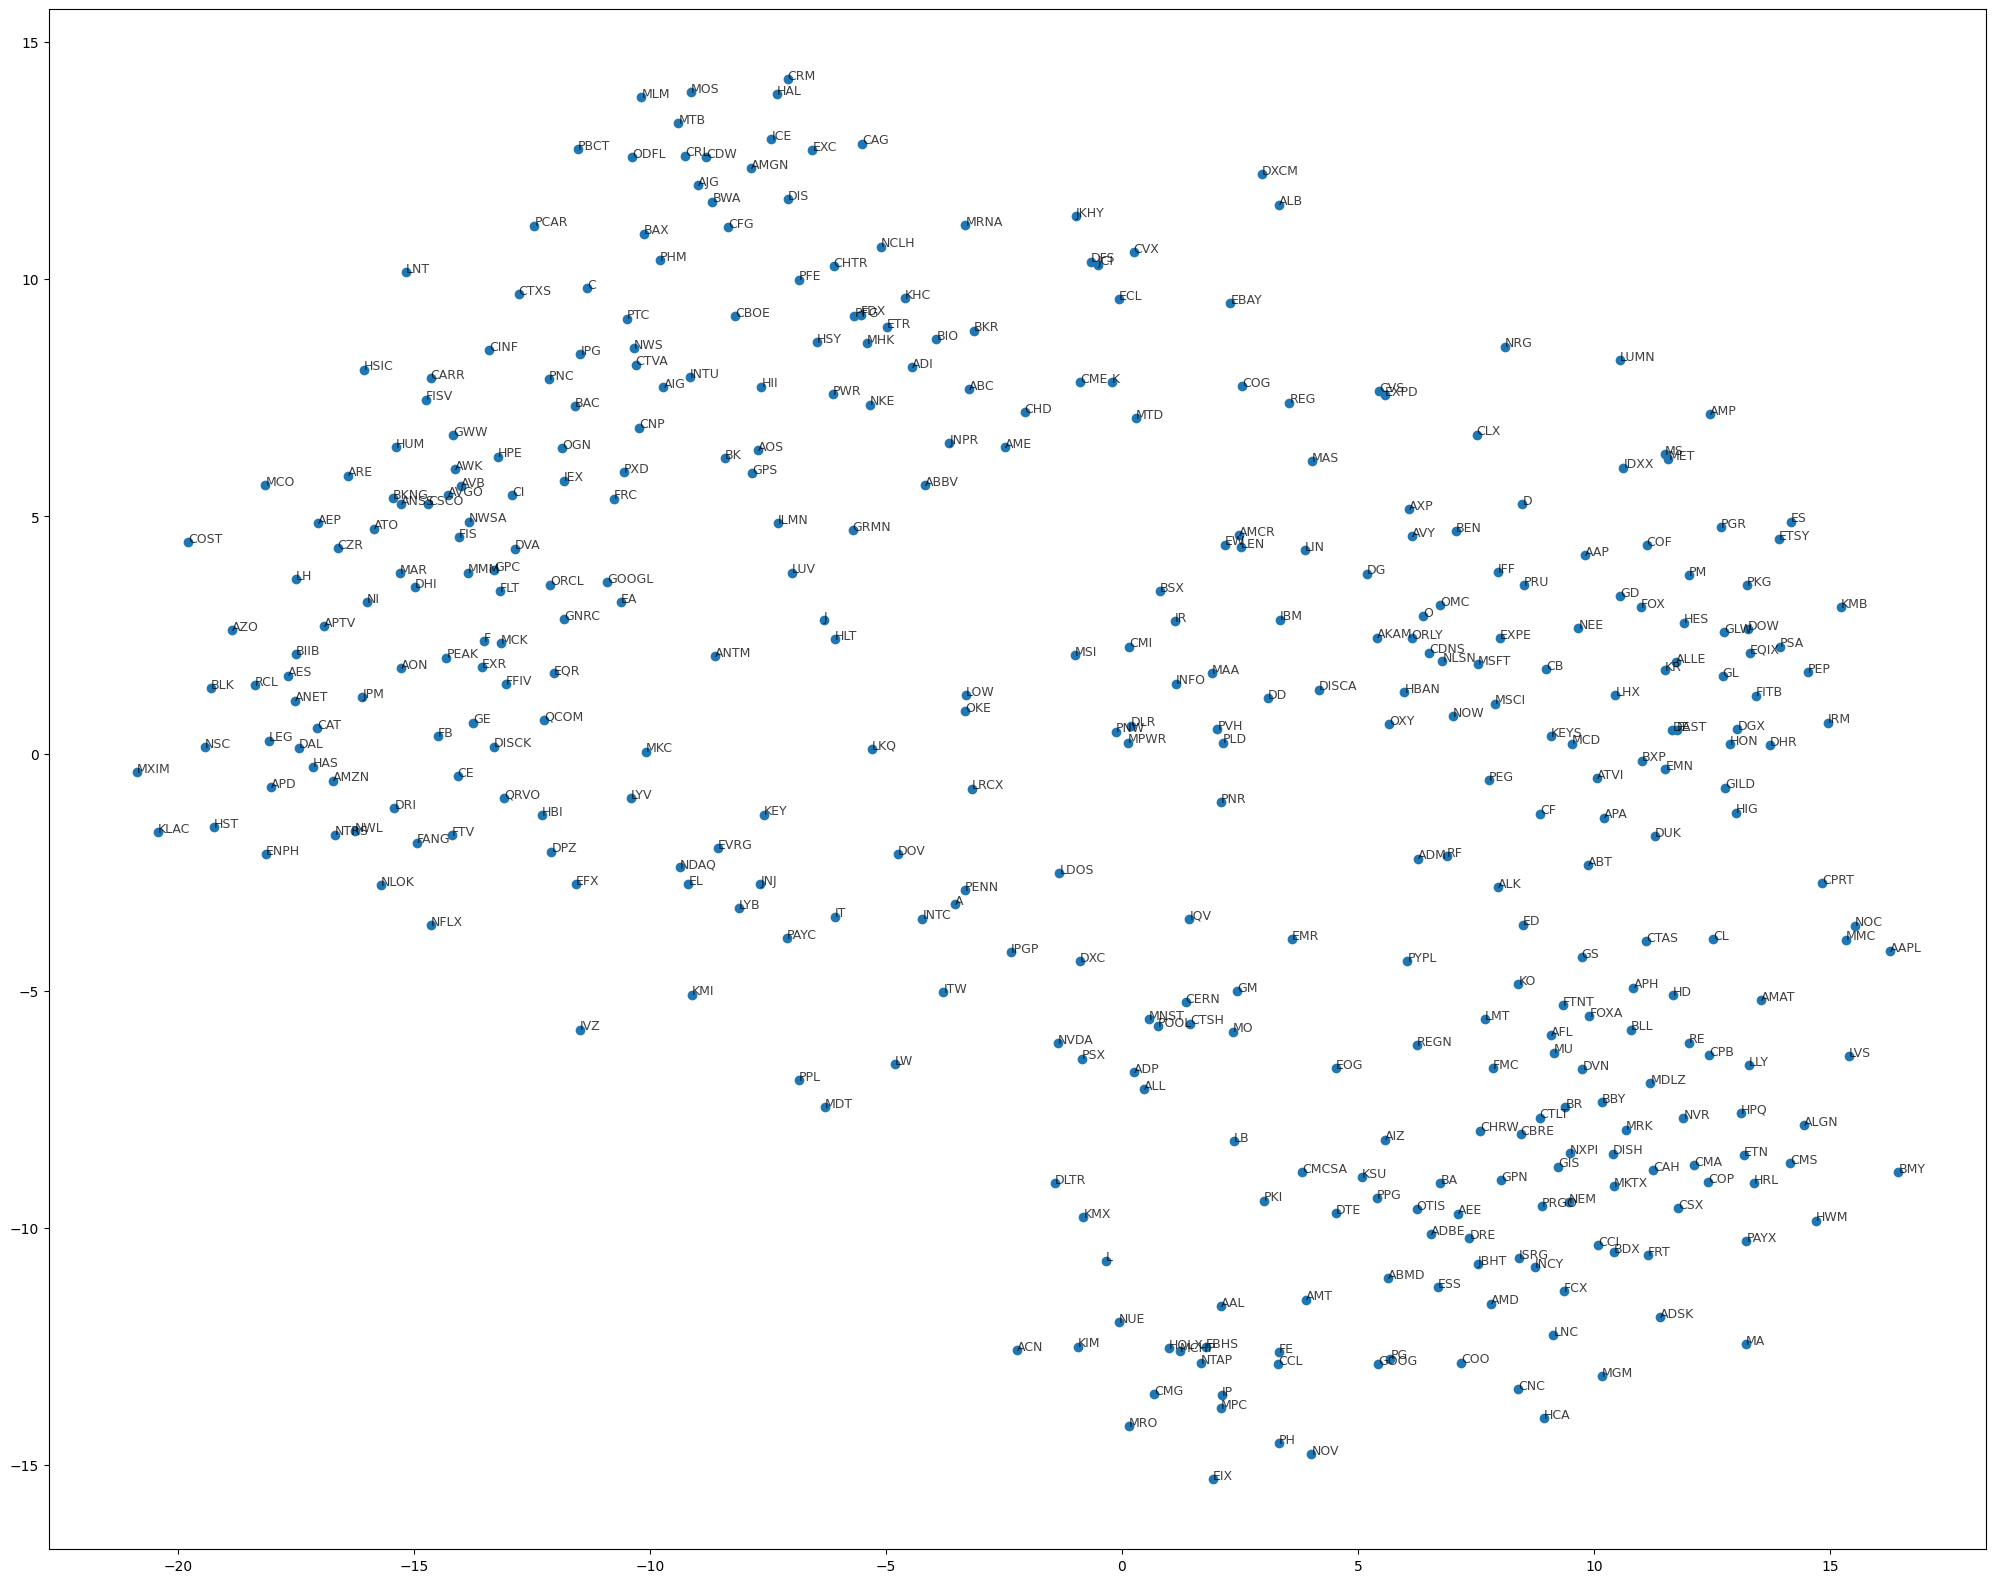

In [29]:
chng = crs.values
companies = crs.columns
nchng = normalize(chng)
model =  TSNE(learning_rate = 50)
# model = TSNE(n_components=2, perplexity=40, learning_rate=50, verbose=1, init='pca', n_iter=2000,
#            early_exaggeration=12)
tsne_features = model.fit_transform(nchng)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
fig, ax = plt.subplots(figsize = [25, 20])
plt.scatter(xs, ys)#, s=3, edgecolors='none', cmap='jet', norm=mpl.colors.LogNorm());
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x, y), fontsize=9, alpha=0.75)
plt.tight_layout
plt.show()

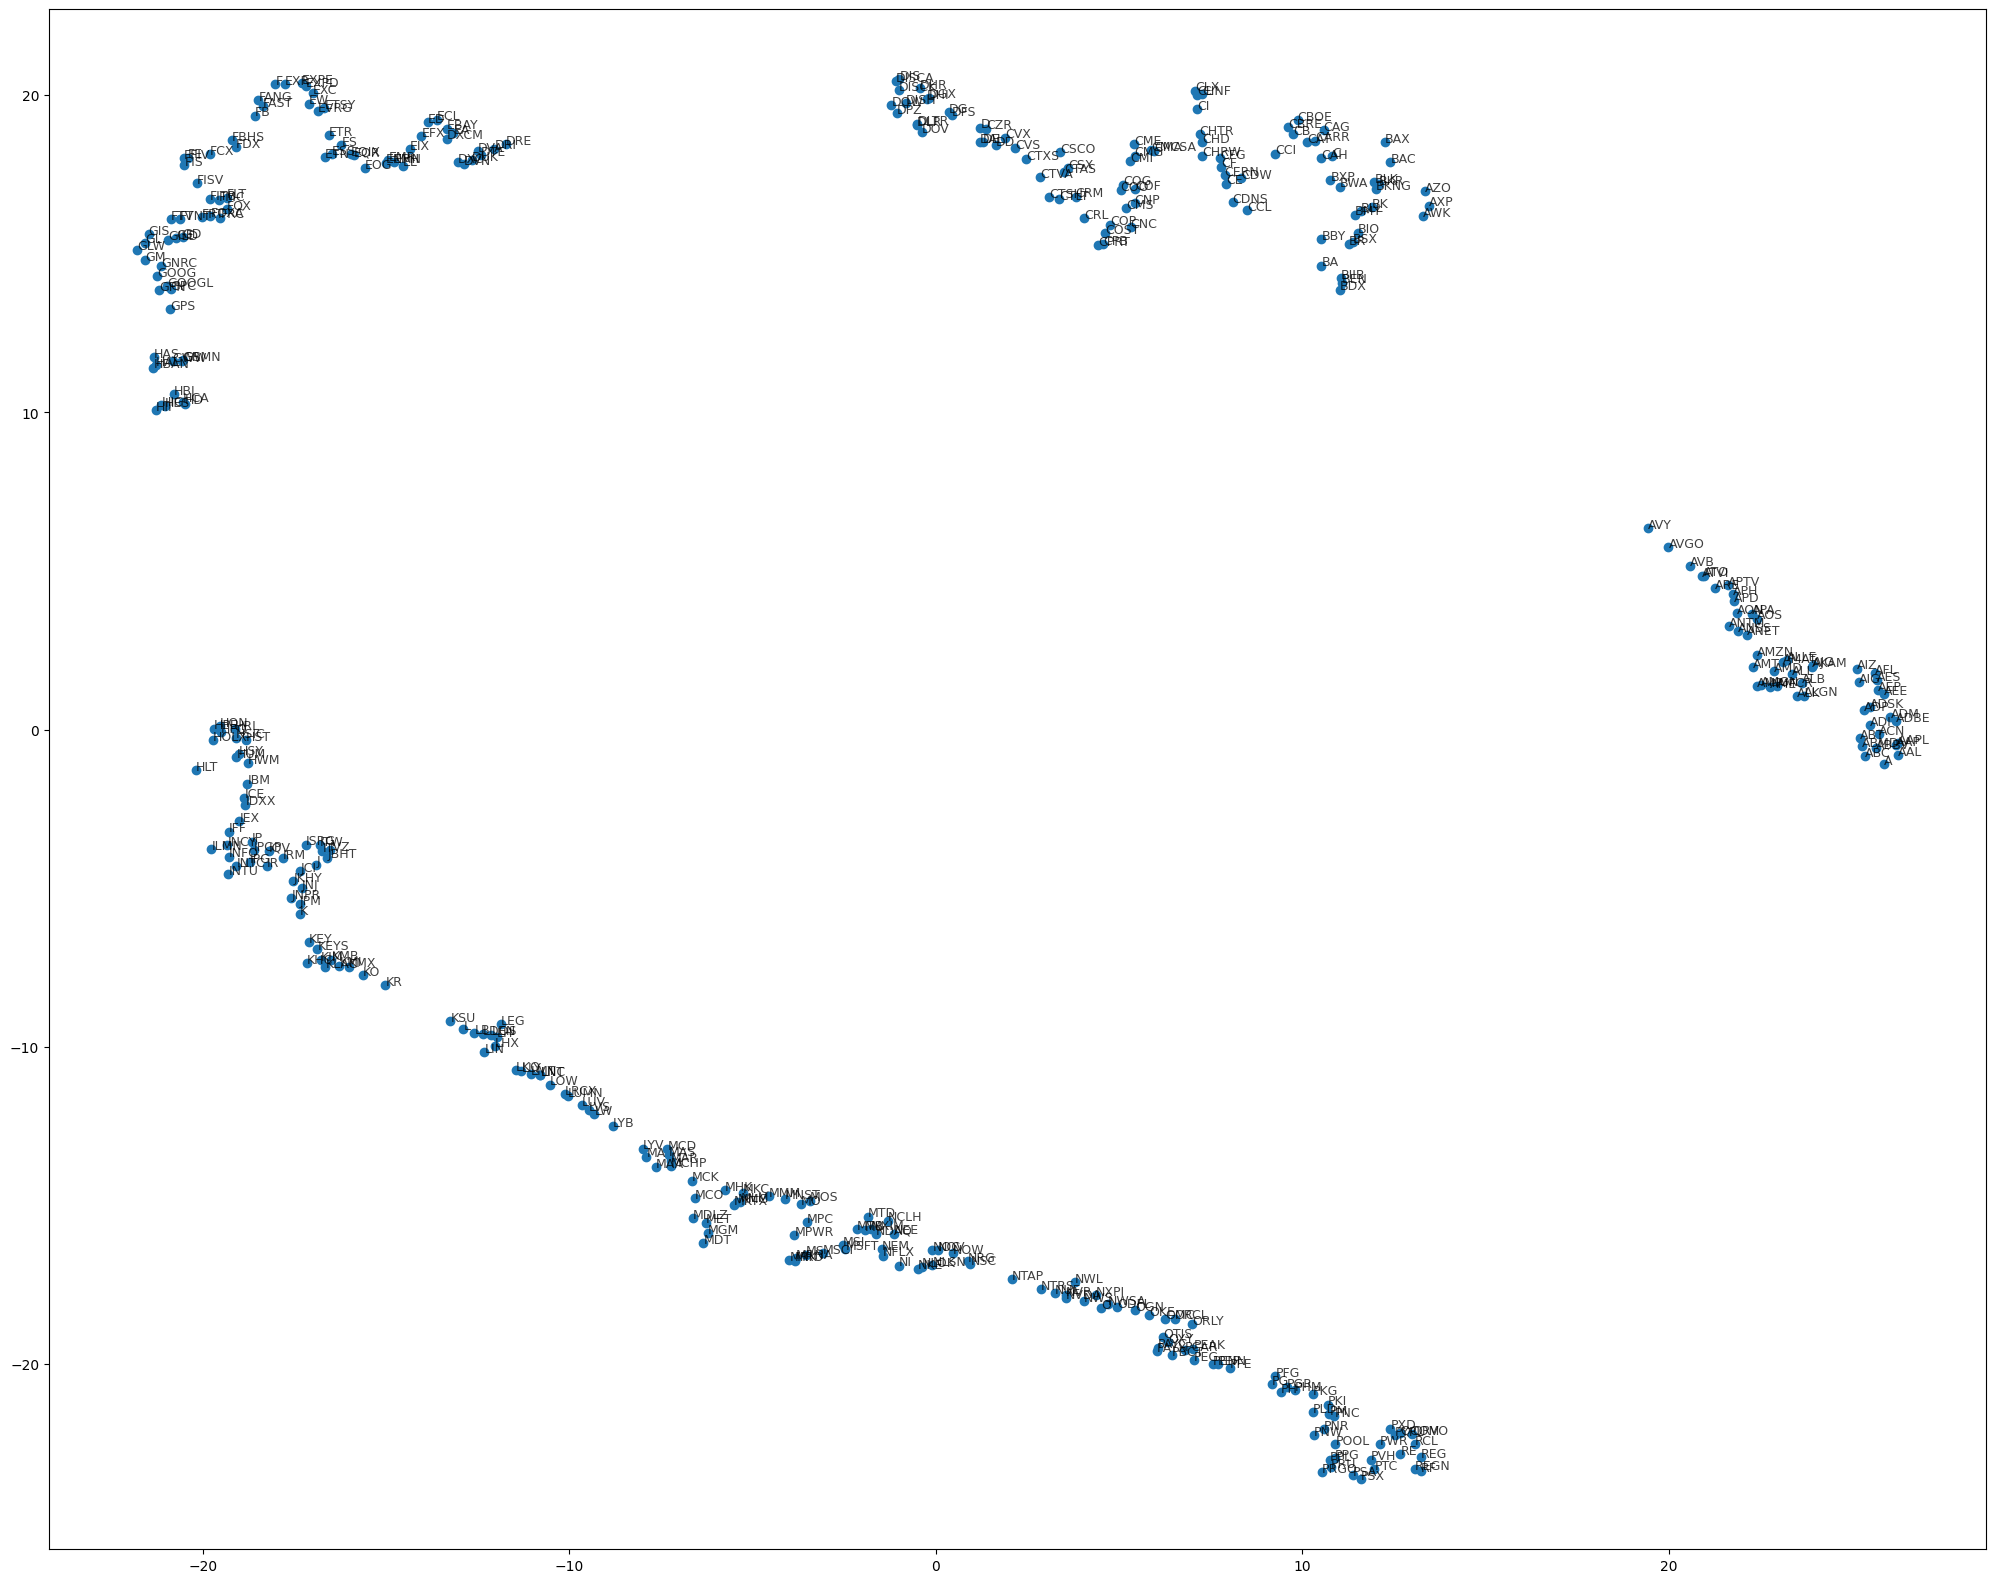

In [30]:
# YOUR CODE HERE
price = icprdf.values
companies = icprdf.columns
nprice = normalize(price)
model =  TSNE(learning_rate = 50)
# model = TSNE(n_components=2, perplexity=40, learning_rate=50, verbose=1, init='pca', n_iter=2000,
#            early_exaggeration=12)
tsne_features = model.fit_transform(nprice)
xs = tsne_features[:,0]
ys = tsne_features[:,1]
fig, ax = plt.subplots(figsize = [25, 20])
plt.scatter(xs, ys)#, s=3, edgecolors='none', cmap='jet', norm=mpl.colors.LogNorm());
for x, y, company in zip(xs, ys, companies):
    plt.annotate(company, (x, y), fontsize=9, alpha=0.75)
plt.tight_layout
plt.show()

## Anomaly Detection (PART-B)

### Load and Preprocess the data

* Inspect the S&P 500 Index Data

In [31]:
path = 'SPY.csv'

In [32]:
# YOUR CODE HERE
dfp=pd.read_csv(path)
dfp.head(-5)

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.983273,480500
1,1993-02-02,44.218750,44.375000,44.125000,44.343750,26.038315,201300
2,1993-02-03,44.406250,44.843750,44.375000,44.812500,26.313566,529400
3,1993-02-04,44.968750,45.093750,44.468750,45.000000,26.423655,531500
4,1993-02-05,44.968750,45.062500,44.718750,44.968750,26.405315,492100
...,...,...,...,...,...,...,...
7124,2021-05-17,415.390015,416.390015,413.359985,415.519989,414.165009,65129200
7125,2021-05-18,415.799988,416.059998,411.769989,411.940002,410.596710,59810200
7126,2021-05-19,406.920013,411.049988,405.329987,410.859985,409.520203,106467100
7127,2021-05-20,411.799988,416.630005,411.670013,415.279999,413.925812,78022200


#### Data Preprocessing (0.5 point)

In [33]:
# YOUR CODE HERE
dfp.isna().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

In [34]:
dfp = dfp[['Date', 'Close']]
print(dfp['Date'])
dfp['Date'] = pd.to_datetime(dfp['Date'])
dfp['Date'].min(), dfp['Date'].max()

0       1993-02-01
1       1993-02-02
2       1993-02-03
3       1993-02-04
4       1993-02-05
           ...    
7129    2021-05-24
7130    2021-05-25
7131    2021-05-26
7132    2021-05-27
7133    2021-05-28
Name: Date, Length: 7134, dtype: object


<ipython-input-34-e897ad1ad3c4>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfp['Date'] = pd.to_datetime(dfp['Date'])


(Timestamp('1993-02-01 00:00:00'), Timestamp('2021-05-28 00:00:00'))

### Create time series data ( 0.5 point)

Select the variable (column) from the data and create the series of data with a window size.

Refer [LSTM Autoencoder](https://medium.com/swlh/time-series-anomaly-detection-with-lstm-autoencoders-7bac1305e713)

In [35]:
# YOUR CODE HERE
import plotly.graph_objects as go
fig = go.Figure()
fig.add_trace(go.Scatter(x=dfp['Date'], y=dfp['Close'], name='Close price'))
fig.update_layout(showlegend=True, title='SPY Stock Price 1993-2021')
fig.show()

In [36]:
train, test = dfp.loc[dfp['Date'] <= '2019-11-03'], dfp.loc[dfp['Date'] > '2019-11-03']
train.shape, test.shape

((6739, 2), (395, 2))

In [37]:
scaler = StandardScaler()
scaler = scaler.fit(train[['Close']])

train['Close'] = scaler.transform(train[['Close']])
test['Close'] = scaler.transform(test[['Close']])

<ipython-input-37-1b05399de220>:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-37-1b05399de220>:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [38]:
train.head()

,Date,Close
0,1993-02-01,-1.479654
1,1993-02-02,-1.478142
2,1993-02-03,-1.470581
3,1993-02-04,-1.467557
4,1993-02-05,-1.468061


In [39]:
TIME_STEPS=30

def create_sequences(X, y, time_steps=TIME_STEPS):
    Xs, ys = [], []
    for i in range(len(X)-time_steps):
        Xs.append(X.iloc[i:(i+time_steps)].values)
        ys.append(y.iloc[i+time_steps])

    return np.array(Xs), np.array(ys)

X_train, y_train = create_sequences(train[['Close']], train['Close'])
X_test, y_test = create_sequences(test[['Close']], test['Close'])

In [40]:
print(f'X Training shape: {X_train.shape}')
print(f'X Testing shape: {X_test.shape}')
print('\n')
print(f'Y Training shape: {y_train.shape}')
print(f'Y Testing shape: {y_test.shape}')

X Training shape: (6709, 30, 1)
X Testing shape: (365, 30, 1)


Y Training shape: (6709,)
Y Testing shape: (365,)


### Build an LSTM Autoencoder ( 1 points)

Autoencoder should take a sequence as input and outputs a sequence of the same shape.

Hint: [LSTM Autoencoder](https://medium.com/swlh/time-series-anomaly-detection-with-lstm-autoencoders-7bac1305e713)

In [41]:
# YOUR CODE HERE
model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(rate=0.2))
model.add(RepeatVector(X_train.shape[1])) #Repeats the input n times, as we want the output shape to be (30,1)
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(rate=0.2))
model.add(TimeDistributed(Dense(X_train.shape[2]))) #applies a specific layer such as Dense to every sample it receives as an input.
model.compile(optimizer='adam', loss='mae')
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 128)               66560     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 repeat_vector (RepeatVecto  (None, 30, 128)           0         
 r)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 30, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 time_distributed (TimeDist  (None, 30, 1)             129       
 ributed)                                               

### Train the Autoencoder (1 point)

* Compile and fit the model with required parameters

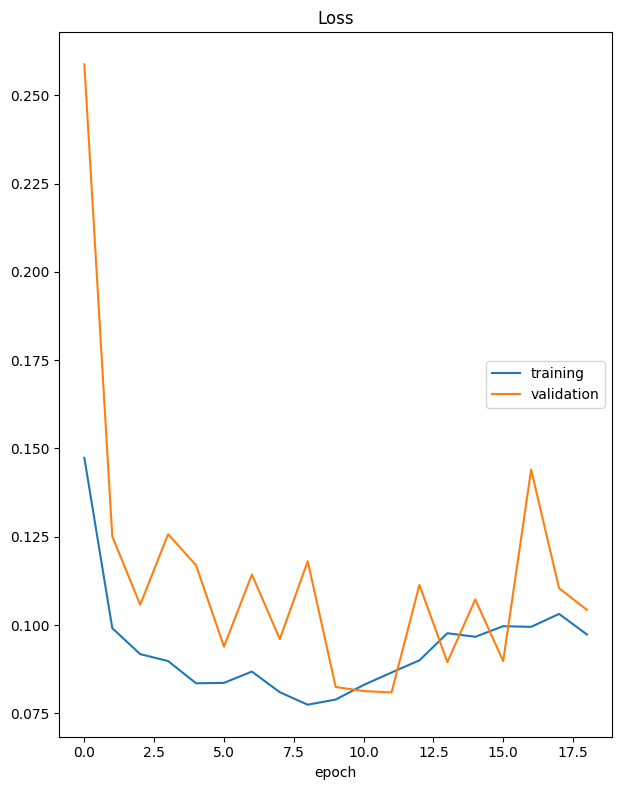

Loss
	training         	 (min:    0.077, max:    0.147, cur:    0.097)
	validation       	 (min:    0.081, max:    0.259, cur:    0.104)
189/189 [==============================] - 2s 9ms/step - loss: 0.0973 - val_loss: 0.1043


In [42]:
# YOUR CODE HERE
es=keras.callbacks.EarlyStopping(monitor='val_loss', patience=7, mode='min')
mc=ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', save_best_only=True,verbose=1)
pt=PlotLossesKerasTF()
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.1,
                    callbacks=[es,mc,pt], shuffle=False)

#### Plot metrics and evaluate the model (1 point)

In [43]:
# YOUR CODE HERE

model.evaluate(X_test, y_test)

12/12 [==============================] - 0s 4ms/step - loss: 0.6042


0.6041653752326965

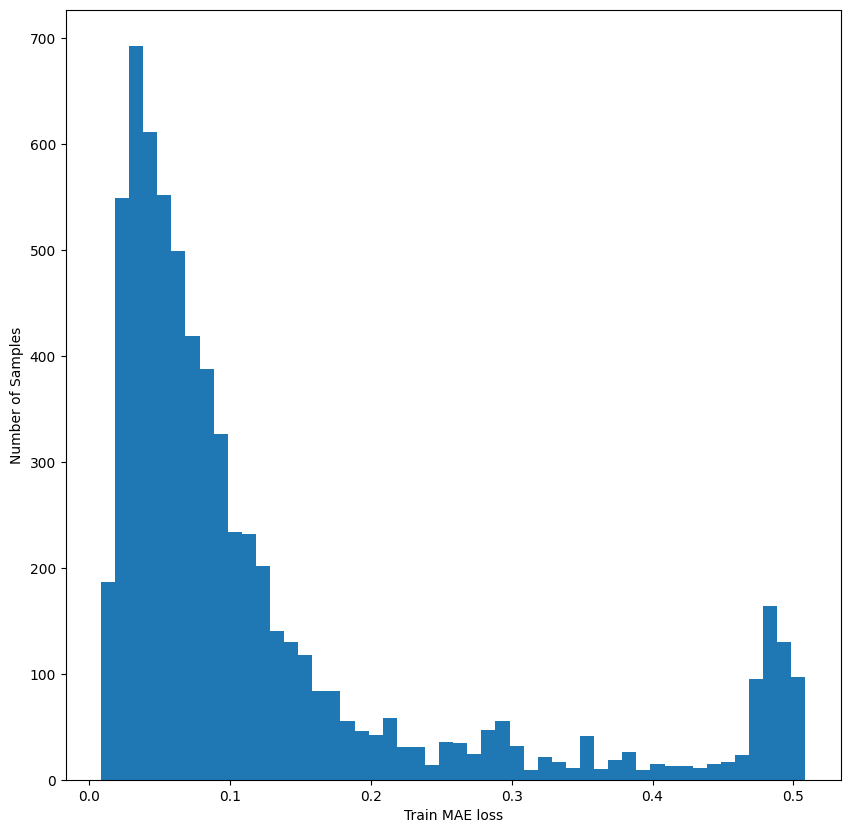

Reconstruction error threshold: 0.48094633218000493


In [44]:
X_train_pred = model.predict(X_train, verbose=0)
train_mae_loss = np.mean(np.abs(X_train_pred - X_train), axis=1)

plt.figure(figsize=(10,10))
plt.hist(train_mae_loss, bins=50)
plt.xlabel('Train MAE loss')
plt.ylabel('Number of Samples');
plt.show()

threshold = np.percentile(train_mae_loss,95) #We can't assume that all training data is normal, otherwise model is flawed
print(f'Reconstruction error threshold: {threshold}')

In [45]:
X_test.shape

(365, 30, 1)

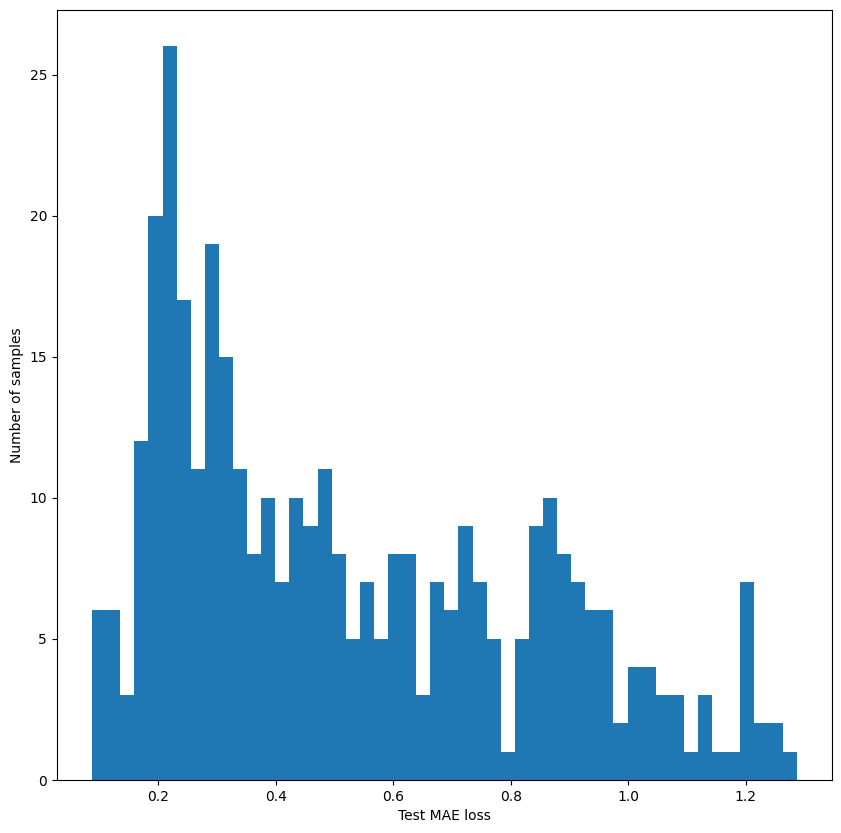

In [46]:
X_test_pred = model.predict(X_test, verbose=0)
test_mae_loss = np.mean(np.abs(X_test_pred-X_test), axis=1)

plt.figure(figsize=(10,10))
plt.hist(test_mae_loss, bins=50)
plt.xlabel('Test MAE loss')
plt.ylabel('Number of samples');
plt.show()

In [47]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df.head()

,Date,Close
6769,2019-12-17,2.961130
6770,2019-12-18,2.961452
6771,2019-12-19,2.982582
6772,2019-12-20,2.979840
6773,2019-12-23,2.987743


In [48]:
test_score_df = pd.DataFrame(test[TIME_STEPS:])
test_score_df['loss'] = test_mae_loss
test_score_df['threshold'] = threshold
test_score_df['anomaly'] = test_score_df['loss'] > test_score_df['threshold']
test_score_df['Close'] = test[TIME_STEPS:]['Close']

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['loss'], name='Test loss'))
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['threshold'], name='Threshold'))
fig.update_layout(showlegend=True, title='Test loss vs. Threshold')
fig.show()

In [49]:
test[TIME_STEPS:]

,Date,Close
6769,2019-12-17,2.961130
6770,2019-12-18,2.961452
6771,2019-12-19,2.982582
6772,2019-12-20,2.979840
6773,2019-12-23,2.987743
...,...,...
7129,2021-05-24,4.567632
7130,2021-05-25,4.552631
7131,2021-05-26,4.566019
7132,2021-05-27,4.569567


In [50]:
anomalies = test_score_df.loc[test_score_df['anomaly'] == True]
anomalies.shape

(169, 5)

In [51]:
test_score_df.head()

,Date,Close,loss,threshold,anomaly
6769,2019-12-17,2.961130,0.193292,0.480946,False
6770,2019-12-18,2.961452,0.198414,0.480946,False
6771,2019-12-19,2.982582,0.209629,0.480946,False
6772,2019-12-20,2.979840,0.206384,0.480946,False
6773,2019-12-23,2.987743,0.213809,0.480946,False


### Detect Anomalies in the S&P 500 Index Data (1.5 points)

* Predict the data and calculate the loss
* Define threshold and detect the anomalies

Discuss the Impact of COVID19 pandemic on stock prices in terms of anomalies detected during the pandemic period in stock prices

In [52]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df['Date'], y=test_score_df['Close'], name='Close price'))
fig.add_trace(go.Scatter(x=anomalies['Date'], y=anomalies['Close'], mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

In [53]:
# YOUR CODE HERE

fig = go.Figure()
fig.add_trace(go.Scatter(x=test_score_df[['Date']], y=scaler.inverse_transform(np.array(test_score_df['Close']).reshape(-1,1)), name='Close price'))
fig.add_trace(go.Scatter(x=anomalies[['Date']], y=scaler.inverse_transform(np.array(anomalies['Close']).reshape(-1,1)), mode='markers', name='Anomaly'))
fig.update_layout(showlegend=True, title='Detected anomalies')
fig.show()

### Report Analysis

* Discuss on the results of T-SNE and PCA
* Dicuss about the results of LSTM autoencoder